In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# Gini Impurity
Gini Impurity measures the disorder of a set of elements. It is calculated as the probability of mislabelling an element assuming that the element is randomly labelled according the the distribution of all the classes in the set. Decision Trees will try to find the split which decreases Gini Impurity the most across the two resulting nodes. For the titanic example it can be calculated as follows (code should be explicit enough):

The internal working of both methods is very similar and both are used for computing the feature/split after every new splitting. But if we compare both the methods then Gini Impurity is more efficient than entropy in terms of computing power. As you can see in the graph for entropy, it first increases up to 1 and then starts decreasing, but in the case of Gini impurity it only goes up to 0.5 and then it starts decreasing, hence it requires less computational power. The range of Entropy lies in between 0 to 1 and the range of Gini Impurity lies in between 0 to 0.5. Hence we can conclude that Gini Impurity is better as compared to entropy for selecting the best features.

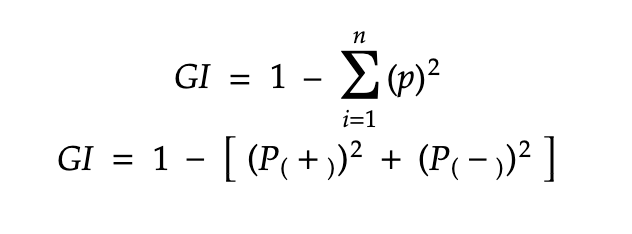

In [244]:
Image("/Users/rahulgarg/github/AnalyticsCourse/images/gini_impurity.png")

In [4]:
train_df = pd.read_csv('/Users/rahulgarg/github/AnalyticsCourse/datasets/titanic/train.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
# GI of survived

In [8]:
1 - ((549/891)**2 + (342/891)**2)

0.4730129578614428

In [9]:
1 - ((0.5)**2 + (0.5)**2)

0.5

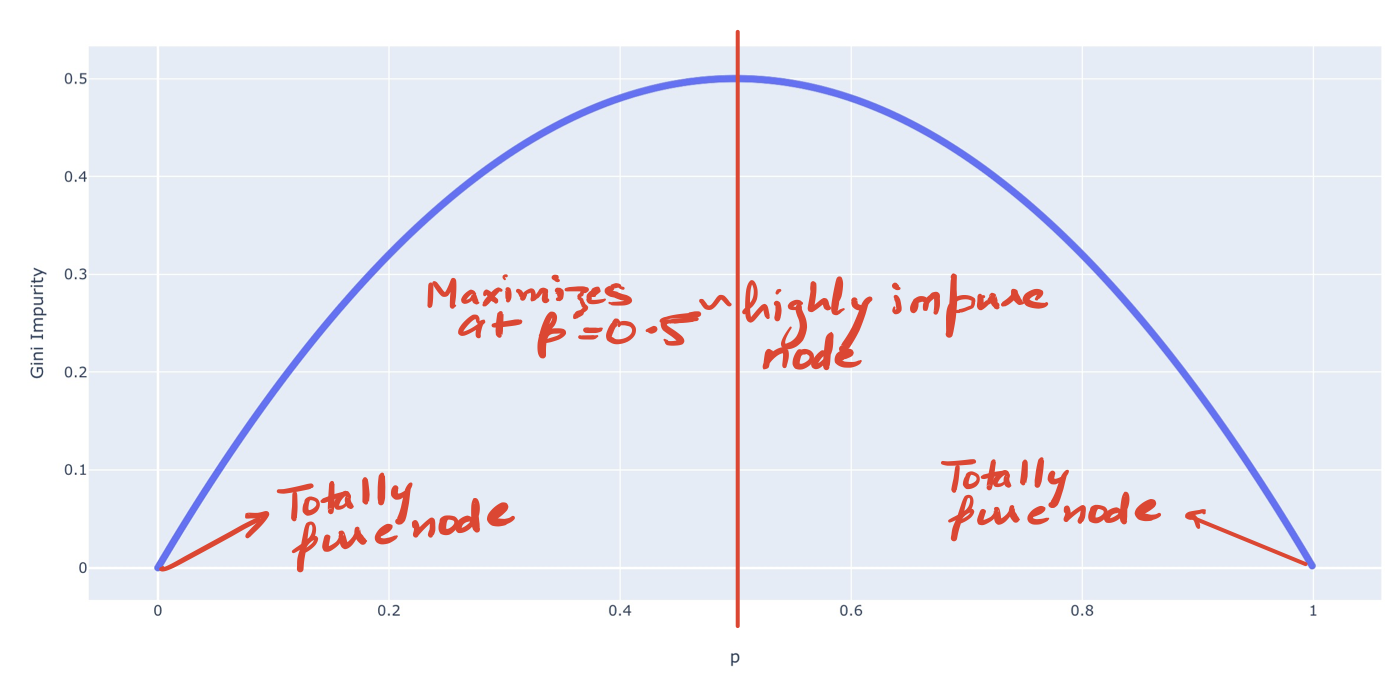

In [245]:
Image("/Users/rahulgarg/github/AnalyticsCourse/images/1_BTbg4pSRhpMp9yvi6z1TJg.png")

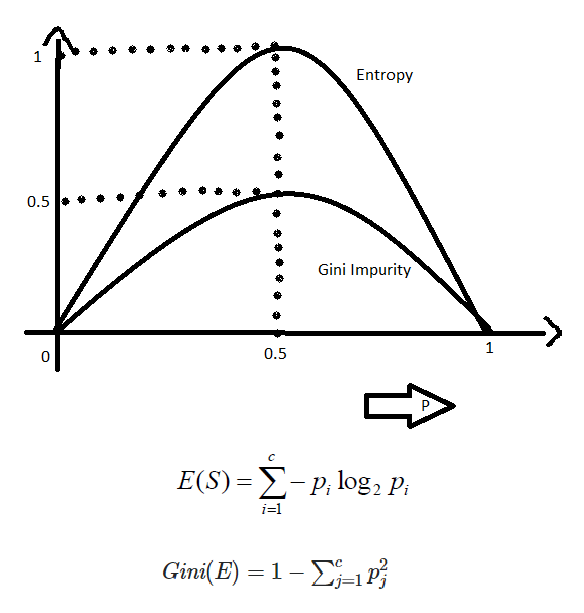

In [242]:
Image("/Users/rahulgarg/github/AnalyticsCourse/images/Gini-Impurity-vs-Entropy.png")

In [10]:
train_df.groupby(['Sex', 'Survived']).agg({'Name':'count'})

Name
Sex    Survived      
female 0           81
       1          233
male   0          468
       1          109

In [12]:
train_df.groupby(['Sex']).agg({'Name':'count'})

,Name
Sex,
female,314
male,577


In [14]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)

    
    gini_impurity = 1 - (survival_prob * survival_prob) - (not_survival_prob * not_survival_prob)
    return gini_impurity

In [15]:
get_gini_impurity(109,577)

0.3064437162277842

In [16]:
1 - (468/577)**2 - (109/577)**2

0.3064437162277842

In [21]:
get_gini_impurity(233,314)

0.3828350034484158

In [18]:
# GINI GIVEN GENDER
314/891*0.3828350034484158 + 577/891*0.3064437162277842

0.3333650003885904

In [20]:
IG1 = 0.4730129578614428 - 0.3333650003885904
IG1

0.1396479574728524

# PCLASS

In [22]:
train_df.groupby(['Pclass', 'Survived']).agg({'Name':'count'})

Name
Pclass Survived      
1      0           80
       1          136
2      0           97
       1           87
3      0          372
       1          119

In [23]:
train_df.groupby(['Pclass']).agg({'Name':'count'})

,Name
Pclass,
1,216
2,184
3,491


In [25]:
get_gini_impurity(136,216)

0.46639231824417005

In [27]:
get_gini_impurity(87,184)

0.49852315689981097

In [28]:
get_gini_impurity(119,491)

0.3672458634234965

In [29]:
216/891*0.46639231824417005 + 184/891*0.49852315689981097 + 491/891* 0.3672458634234965

0.41839138109005924

In [31]:
IG2 = 0.4730129578614428 - 0.41839138109005924
IG2

0.05462157677138357

In [247]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144276

In [248]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 549)
gini_impurity_men

0.3182471192862666

In [249]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 342)
gini_impurity_women

0.43427037379022604

# Read DataFrames

In [38]:
train_df = pd.read_csv('/Users/rahulgarg/github/AnalyticsCourse/datasets/titanic/train.csv')
test_df = pd.read_csv('/Users/rahulgarg/github/AnalyticsCourse/datasets/titanic/test.csv')

In [39]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [40]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [41]:
train_df['Fare'].mean()

32.2042079685746

In [42]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [43]:
# Impute Missing Values
train_df['Age'] = train_df.Age.fillna(28.0)

train_df['Fare'] = train_df['Fare'].astype(int)

train_df['Embarked'] = train_df.Embarked.fillna('S')

In [44]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8,NaN,S


In [45]:
# # Create Dummy Columns
# from sklearn import preprocessing #import
# le = preprocessing.LabelEncoder() #instantiate
# le.fit(train_df.Sex) #Fit

# train_df['gender_male'] =le.transform(train_df.Sex)
# train_embarked_encoded =  pd.get_dummies(train_df.Embarked, drop_first = True,  prefix='Embarked')

# test_df['gender_male'] =le.transform(test_df.Sex)
# test_embarked_encoded =  pd.get_dummies(test_df.Embarked, drop_first = True,  prefix='Embarked')

In [46]:
# # Store our test passenger IDs for easy access
# PassengerId = test_df['PassengerId']

In [47]:
# train = pd.concat([train_df, train_embarked_encoded], axis =1)
# test = pd.concat([test_df, test_embarked_encoded], axis =1)

In [48]:
# Create Dummy Columns
from sklearn import preprocessing #import
le_gender = preprocessing.LabelEncoder() #instantiate
le_gender.fit(train_df.Sex) #Fit

LabelEncoder()

In [49]:
train_df['gender_encoded'] =le_gender.transform(train_df.Sex)

In [50]:
# Create Dummy Columns
from sklearn import preprocessing #import
le_embarked = preprocessing.LabelEncoder() #instantiate
le_embarked.fit(train_df.Embarked) #Fit

LabelEncoder()

In [51]:
train_df['embarked_encoded'] =le_embarked.transform(train_df.Embarked)

In [52]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,gender_encoded,embarked_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7,NaN,S,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7,NaN,S,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53,C123,S,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8,NaN,S,1,2
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8,NaN,Q,1,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51,E46,S,1,2
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21,NaN,S,1,2
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11,NaN,S,0,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30,NaN,C,0,0


In [53]:
X = pd.DataFrame(train_df.loc[:,['Pclass','Age','Parch','Fare','gender_encoded','embarked_encoded' ]])
y = train_df.Survived # Step 0

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier #Import

In [89]:
clf_entropy = DecisionTreeClassifier(criterion='gini', random_state = 0, max_depth = 4) #instantiate

In [90]:
clf_entropy.fit(X,y) # Fit

DecisionTreeClassifier(max_depth=4, random_state=0)

In [91]:
predicted_survived = pd.Series(clf_entropy.predict(X)) #predict
predicted_survived

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Length: 891, dtype: int64

In [92]:
clf_entropy.score(X,y)

0.8338945005611672

In [93]:
from sklearn.metrics import confusion_matrix

In [94]:
cm = confusion_matrix(train_df.Survived, predicted_survived)

In [96]:
pd.DataFrame(cm,columns =  ['Predicted_0','Predicted_1'], index = ['Survived_0','Survived_1'])

,Predicted_0,Predicted_1
Survived_0,498,51
Survived_1,97,245


In [97]:
accuracy_score(train_df.Survived, predicted_survived)

0.8338945005611672

In [98]:
from sklearn.metrics import f1_score
f1_score(train_df.Survived, predicted_survived)

0.768025078369906

## Visualise Decision tree

In [99]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

In [100]:
dot_data = StringIO()
export_graphviz(clf_entropy, out_file=dot_data,  max_depth = None,
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

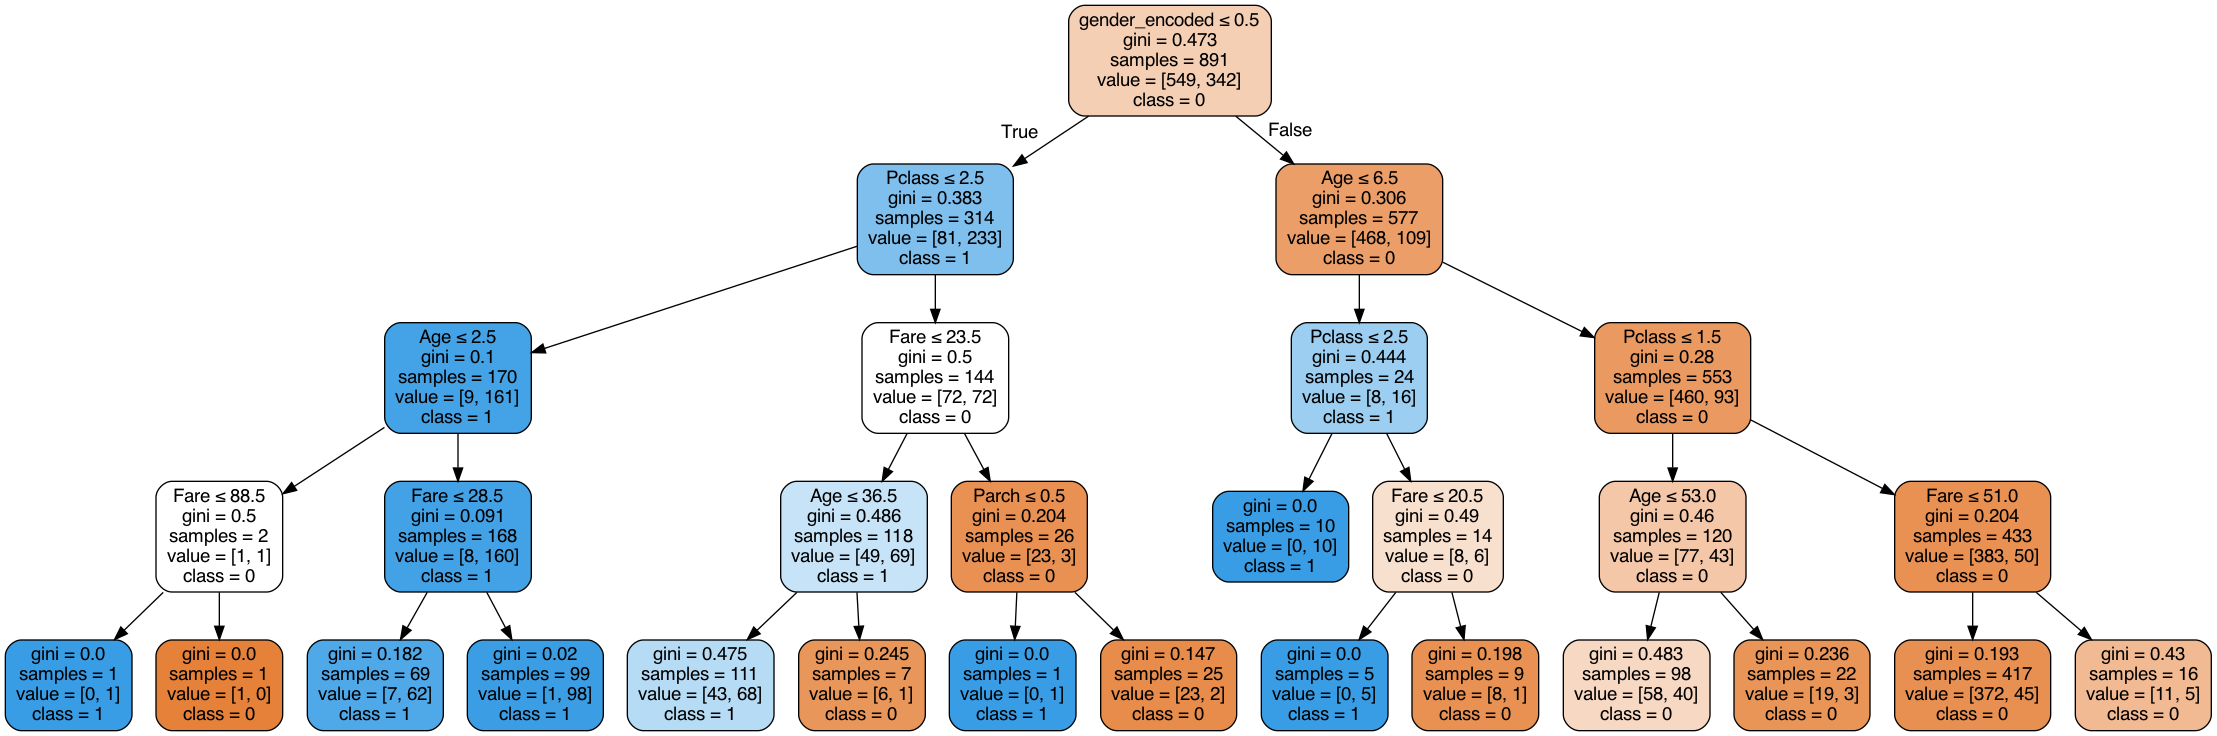

In [101]:
graph.write_png('tree1.png')
Image(graph.create_png())

# Visualisation Type 2

In [102]:
list(X)

['Pclass', 'Age', 'Parch', 'Fare', 'gender_encoded', 'embarked_encoded']

In [103]:
FEATURE_NAMES = list(X)

In [104]:
from sklearn.tree import export_graphviz
export_graphviz(clf_entropy, 'tree2.dot', feature_names = X.columns, max_depth = None)

In [105]:
! dot -Tpng tree2.dot -o tree2.png

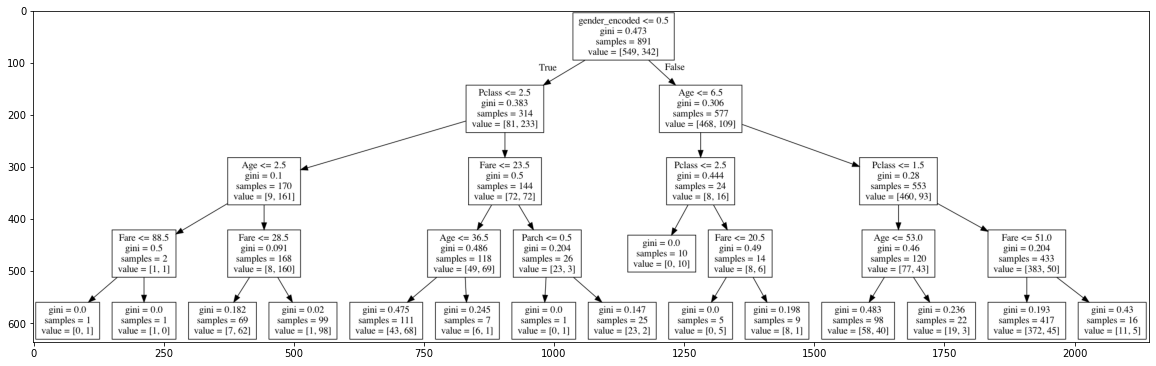

In [106]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree2.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

In [107]:
train = pd.DataFrame(train_df.loc[:,['Survived','Pclass','Age','Parch','Fare','gender_encoded','embarked_encoded' ]])
test = pd.DataFrame(test_df.loc[:,['Pclass','Age','Parch','Fare','gender_encoded','embarked_encoded' ]])

In [108]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, 10)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.786729
         2          0.766654
         3          0.809201
         4          0.811448
         5          0.805818
         6          0.812597
         7          0.810362
         8          0.808127
         9          0.800262


## predictions on test set

In [109]:
test_df = pd.read_csv('/Users/rahulgarg/github/AnalyticsCourse/datasets/titanic/test.csv', index_col = 0)
test_df['Age'] = test_df.Age.fillna(28.0)
test_df['Fare'] = test_df['Fare'].fillna(31).astype(int)
test_df['Embarked'] = test_df.Embarked.fillna('S')


In [110]:
test_df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7,NaN,S


In [111]:
test_df['gender_encoded'] =le_gender.transform(test_df.Sex)

In [112]:
test_df['embarked_encoded'] =le_embarked.transform(test_df.Embarked)

In [113]:
test_df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,gender_encoded,embarked_encoded
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7,NaN,Q,1,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7,NaN,S,0,2
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9,NaN,Q,1,1
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8,NaN,S,1,2
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12,NaN,S,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8,NaN,S,1,2
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108,C105,C,0,0
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7,NaN,S,1,2


In [114]:
X_test = pd.DataFrame(test_df.loc[:,['Pclass','Age','Parch','Fare','gender_encoded','embarked_encoded' ]])
# y = test_df.Survived # Step 0

In [115]:
test_preds = clf_entropy.predict(X_test) #predict

In [116]:
test_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [117]:
submission_df = pd.DataFrame(test_preds, index= test_df.index, columns = ['Survived'])

In [118]:
submission_df

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [119]:
submission_df.to_csv('/Users/rahulgarg/github/AnalyticsCourse/kaggle_submissions/titanic_submission_6.csv')

In [69]:
train = pd.DataFrame(train.loc[:,['Survived','Pclass','Age','Parch','Fare','gender_male','Embarked_Q','Embarked_S' ]])
test = pd.DataFrame(test.loc[:,['Pclass','Age','Parch','Fare','gender_male','Embarked_Q','Embarked_S' ]])

The best max_depth parameter seems therefore to be 4 (81% average accuracy across the 10 folds), and feeding the model with 7 depth will probably lead to over-fitting. We'll therefore use 4 as the max_depth parameter for our final model.